In [1]:
import numpy as np
import pandas as pd
import implicit
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras import layers, Model

from sklearn.metrics.pairwise import cosine_similarity

c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Podminena pravdepodobnost

![prob](in/prob.png)

In [2]:
data = pd.read_excel('in/data.xlsx')
data.head(5)

,user_id,user_name,user_feature,user_feature_bin,order_id,item_id,item_name,count,diary,bakery,alcohol,tabaco,food,drink,unhealthy,healthy
0,0,Oliver Twist,alcoholic,1,1,0,butter,1,1,0,0,0,1,0,0,1
1,1,Jean,teetotaller,0,2,0,butter,5,1,0,0,0,1,0,0,1
2,1,Jean,teetotaller,0,3,1,baguette,10,0,1,0,0,1,0,0,1
3,2,Rasputin,alcoholic,1,4,2,vodka,2,0,0,1,0,0,1,1,0
4,2,Rasputin,alcoholic,1,5,3,cigarettes,2,0,0,0,1,0,0,1,0


In [3]:
df = data.copy()

In [4]:
# 1. TVORBA MATICE SPOLEČNÝCH VÝSKYTŮ (Jedním příkazem)
# crosstab vytvoří tabulku, kde vidíš, kolik lidí koupilo A i B zároveň
common_purchases = pd.crosstab(df.user_id, df.item_name)
co_occurrence = common_purchases.T.dot(common_purchases)

# 2. VÝPOČET PRO MÁSLO (BUTTER)
target = 'butter'
count_a = co_occurrence.loc[target, target] # Celkem nákupů másla

# 3. VÝPOČET PRAVDĚPODOBNOSTÍ
# Vezmeme řádek pro máslo, vydělíme ho celkovým počtem másel a seřadíme
results = (co_occurrence[target] / count_a * 100).sort_values(ascending=False)

# 4. VÝPIS (Odstraníme máslo samotné, u kterého je 100%)
print(f"Pokud je v košíku {target.upper()}, pravděpodobnost dalšího nákupu je:")
print(results.drop(target).round(1).astype(str) + ' %')

Pokud je v košíku BUTTER, pravděpodobnost dalšího nákupu je:
item_name
baguette      66.7 %
cigarettes    33.3 %
milk          33.3 %
rolls         33.3 %
rum            0.0 %
vodka          0.0 %
Name: butter, dtype: object


In [5]:
common_purchases

item_name,baguette,butter,cigarettes,milk,rolls,rum,vodka
user_id,,,,,,,
0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0
2,0,0,1,0,0,1,1
3,1,1,1,1,1,0,0


# Content based filtering

In [6]:
df.head(5)

,user_id,user_name,user_feature,user_feature_bin,order_id,item_id,item_name,count,diary,bakery,alcohol,tabaco,food,drink,unhealthy,healthy
0,0,Oliver Twist,alcoholic,1,1,0,butter,1,1,0,0,0,1,0,0,1
1,1,Jean,teetotaller,0,2,0,butter,5,1,0,0,0,1,0,0,1
2,1,Jean,teetotaller,0,3,1,baguette,10,0,1,0,0,1,0,0,1
3,2,Rasputin,alcoholic,1,4,2,vodka,2,0,0,1,0,0,1,1,0
4,2,Rasputin,alcoholic,1,5,3,cigarettes,2,0,0,0,1,0,0,1,0


In [7]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# --- Změna 1: Přidány sloupce do výběru a opraven název na item_name ---
df_items = df[['item_name', 'food', 'drink', 'healthy', 'unhealthy', 'diary', 'bakery', 'alcohol', 'tabaco']].drop_duplicates()

# Vytvoříme matici příznaků (features)
features = df_items[['food', 'drink', 'healthy', 'unhealthy', 'diary', 'bakery', 'alcohol', 'tabaco']].values

# Vypočítáme kosinovou podobnost (výsledek 0 až 1)
similarity_matrix = cosine_similarity(features)

# --- Změna 2: Opraveny názvy v indexu a sloupcích na item_name ---
sim_df = pd.DataFrame(
    similarity_matrix,
    index=df_items['item_name'],
    columns=df_items['item_name']
).rename_axis(None, axis=0).rename_axis(None, axis=1)

print("Matice podobnosti produktů (Content-Based):")
sim_df.round(2)

Matice podobnosti produktů (Content-Based):


,butter,baguette,vodka,cigarettes,rum,rolls,milk
butter,1.00,0.67,0.00,0.00,0.00,0.67,0.41
baguette,0.67,1.00,0.00,0.00,0.00,1.00,0.00
vodka,0.00,0.00,1.00,0.41,1.00,0.00,0.41
cigarettes,0.00,0.00,0.41,1.00,0.41,0.00,0.00
rum,0.00,0.00,1.00,0.41,1.00,0.00,0.41
rolls,0.67,1.00,0.00,0.00,0.00,1.00,0.00
milk,0.41,0.00,0.41,0.00,0.41,0.00,1.00


In [8]:
# --- 1. VYTVOŘENÍ VEKTORŮ ---
df_vectors = df_items.copy()

# Místo vypisování sloupců použijeme už existující 'features'
df_vectors['vector'] = features.tolist()

# --- 2. TISK ---
print("\n2. REPREZENTACE PRODUKTŮ JAKO VEKTORŮ:")
print(df_vectors[['item_name', 'vector']].set_index('item_name'))


2. REPREZENTACE PRODUKTŮ JAKO VEKTORŮ:
                              vector
item_name                           
butter      [1, 0, 1, 0, 1, 0, 0, 0]
baguette    [1, 0, 1, 0, 0, 1, 0, 0]
vodka       [0, 1, 0, 1, 0, 0, 1, 0]
cigarettes  [0, 0, 0, 1, 0, 0, 0, 1]
rum         [0, 1, 0, 1, 0, 0, 1, 0]
rolls       [1, 0, 1, 0, 0, 1, 0, 0]
milk        [0, 1, 0, 0, 1, 0, 0, 0]


In [9]:
def recommend_similar(item_name, top_n=3):
    # 1. Vezmeme sloupec pro daný produkt
    similar_scores = sim_df[item_name].sort_values(ascending=False)
    
    # 2. ODSTRANÍME PODLE JMÉNA (vyloučíme přesně ten produkt, co držíme v ruce)
    recommendations = similar_scores.drop(labels=[item_name])
    
    # 3. Pokud máš v datech duplicity (více stejných položek), odstraníme i ty
    recommendations = recommendations.groupby(level=0).max().sort_values(ascending=False)
    
    print(f'With chosen item "{item_name}", we recommend:')
    return recommendations.head(top_n)

In [10]:
# Choose item
recommend_similar('vodka')

With chosen item "vodka", we recommend:


rum           1.000000
cigarettes    0.408248
milk          0.408248
Name: vodka, dtype: float64

# Collaborative filtering

## Memory based filtering

In [11]:
'''
Tato metoda pracuje přímo s celou maticí interakcí (všemi hodnoceními), která musí být uložena v paměti.

Jak funguje: Hledá „sousedy“. Buď hledá podobné uživatele (User-based), nebo podobné položky (Item-based) pomocí jednoduchých statistických výpočtů (např. kosinová podobnost).

Analogie: Představte si to jako dotazování přátel: „Kterým mým kamarádům se líbil stejný film jako mně? A na co dalšího se dívali?“.

Výhody: Je to velmi intuitivní, snadno se vysvětlí („Doporučujeme vám X, protože panu Novákovi se také líbilo Y“) a systém okamžitě reaguje na nová data.

Nevýhody: Špatně se škáluje. Pokud máte miliony uživatelů a položek, výpočet podobnosti mezi všemi trvá příliš dlouho.

'''

'\nTato metoda pracuje přímo s celou maticí interakcí (všemi hodnoceními), která musí být uložena v paměti.\n\nJak funguje: Hledá „sousedy“. Buď hledá podobné uživatele (User-based), nebo podobné položky (Item-based) pomocí jednoduchých statistických výpočtů (např. kosinová podobnost).\n\nAnalogie: Představte si to jako dotazování přátel: „Kterým mým kamarádům se líbil stejný film jako mně? A na co dalšího se dívali?“.\n\nVýhody: Je to velmi intuitivní, snadno se vysvětlí („Doporučujeme vám X, protože panu Novákovi se také líbilo Y“) a systém okamžitě reaguje na nová data.\n\nNevýhody: Špatně se škáluje. Pokud máte miliony uživatelů a položek, výpočet podobnosti mezi všemi trvá příliš dlouho.\n\n'

## Model based filtering

In [12]:
'''
Tato metoda se snaží z dat vytěžit skryté vzorce a převést je do kompaktního modelu.

Jak funguje: Používá algoritmy jako Matrix Factorization (např. vaše ALS) nebo neuronové sítě. Velkou matici rozloží na menší vektory (tzv. latentní faktory), které reprezentují skryté vlastnosti (např. u filmu to může být „míra akce“, „atmosféra“), aniž by je kdokoli musel ručně zadávat.

Analogie: Je to jako najmout si analytika, který prostuduje tisíce nákupů a pak si do sešitu udělá vzorce, podle kterých pak rychle předpoví, co si koupíte příště.

Výhody: Skvěle zvládá obrovská data (je škálovatelný) a je obvykle přesnější, protože odhalí i netradiční souvislosti, které sousedský přístup mine.

Nevýhody: „Black box“ – je těžké uživateli vysvětlit, proč mu systém něco doporučil. Model se také musí pravidelně přetrénovávat (není tak adaptivní na změny v reálném čase).
'''


'\nTato metoda se snaží z dat vytěžit skryté vzorce a převést je do kompaktního modelu.\n\nJak funguje: Používá algoritmy jako Matrix Factorization (např. vaše ALS) nebo neuronové sítě. Velkou matici rozloží na menší vektory (tzv. latentní faktory), které reprezentují skryté vlastnosti (např. u filmu to může být „míra akce“, „atmosféra“), aniž by je kdokoli musel ručně zadávat.\n\nAnalogie: Je to jako najmout si analytika, který prostuduje tisíce nákupů a pak si do sešitu udělá vzorce, podle kterých pak rychle předpoví, co si koupíte příště.\n\nVýhody: Skvěle zvládá obrovská data (je škálovatelný) a je obvykle přesnější, protože odhalí i netradiční souvislosti, které sousedský přístup mine.\n\nNevýhody: „Black box“ – je těžké uživateli vysvětlit, proč mu systém něco doporučil. Model se také musí pravidelně přetrénovávat (není tak adaptivní na změny v reálném čase).\n'

# ALS (Matrix Factorization)

In [13]:
# Doporučení
user_id_to_check = 2

In [14]:
# 2. Faktorizace a Mapování
data["user_idx"] = pd.factorize(data["user_id"])[0]
data["item_idx"] = pd.factorize(data["item_id"])[0]

# Slovníky názvů (ZDE PŘIDÁNO MAPOVÁNÍ JMÉN)
product_names = dict(zip(data.item_idx, data.item_name))
user_names = dict(zip(data.user_idx, data.user_name)) 


# 2. ROBUSTNÍ MAPOVÁNÍ (Tady je ta oprava)
# Mapujeme MATICOVÝ INDEX přímo na JMÉNO z tabulky
user_idx_to_name = data[['user_idx', 'user_name']].drop_duplicates().set_index('user_idx')['user_name'].to_dict()
item_idx_to_name = data[['item_idx', 'item_name']].drop_duplicates().set_index('item_idx')['item_name'].to_dict()



# 3. Matice (CSR formát přímo)
user_item = csr_matrix((
    data["count"].astype(float), 
    (data["user_idx"], data["item_idx"])
))

# 4. ALS Trénink (Váhu 40 definujeme jako alfa)
alpha = 40
model = implicit.als.AlternatingLeastSquares(factors=2, 
                                             iterations=50, 
                                             regularization=0.5,
                                             random_state=42
                                             )
model.fit(user_item * alpha)

# Získáme jméno ze slovníku podle indexu
user_name = user_names.get(user_id_to_check, f"ID {user_id_to_check}")

# Výpočet doporučení
ids, scores = model.recommend(user_id_to_check, (user_item * alpha)[user_id_to_check], 
                              N=7, 
                              filter_already_liked_items=False
                              )

# VÝPIS SE JMÉNEM
print(f"\nTOP doporučení pro uživatele {user_name}:") 
for i, s in zip(ids, scores):
    print(f"{product_names[i]:<15} skóre: {s:.3f}")

c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [00:00<00:00, 4781.36it/s]


TOP doporučení pro uživatele Rasputin:
rum             skóre: 0.995
cigarettes      skóre: 0.990
vodka           skóre: 0.986
milk            skóre: 0.217
rolls           skóre: 0.217
baguette        skóre: -0.843
butter          skóre: -0.860


In [15]:
# 1. Získání latentních faktorů (souřadnic)
user_factors = model.user_factors
item_factors = model.item_factors

# 2. Zobrazení faktorů produktů (Item Latent Factors)
print("--- LATENTNÍ FAKTORY PRODUKTŮ (Souřadnice na mapě) ---")
item_df = pd.DataFrame(
    item_factors, 
    index=[product_names[i] for i in range(len(product_names))],
    columns=[f"Faktor_{i+1}" for i in range(item_factors.shape[1])]
)
print(item_df.round(4))

print("\n--- LATENTNÍ FAKTORY UŽIVATELŮ ---")
user_df = pd.DataFrame(
    user_factors,
    index=[f"User_{i}" for i in range(user_factors.shape[0])],
    columns=[f"Faktor_{i+1}" for i in range(user_factors.shape[1])]
)

print(user_df.round(4))


--- LATENTNÍ FAKTORY PRODUKTŮ (Souřadnice na mapě) ---
            Faktor_1  Faktor_2
butter       -0.3522    0.4881
baguette     -0.3447    0.4821
vodka         0.4425   -0.2643
cigarettes    0.4588   -0.1527
rum           0.4461   -0.2665
rolls         0.1199    0.1148
milk          0.1199    0.1148

--- LATENTNÍ FAKTORY UŽIVATELŮ ---
        Faktor_1  Faktor_2
User_0   -0.3813    1.6068
User_1   -0.4049    1.7737
User_2    2.0680   -0.2701
User_3    3.7696    4.7705


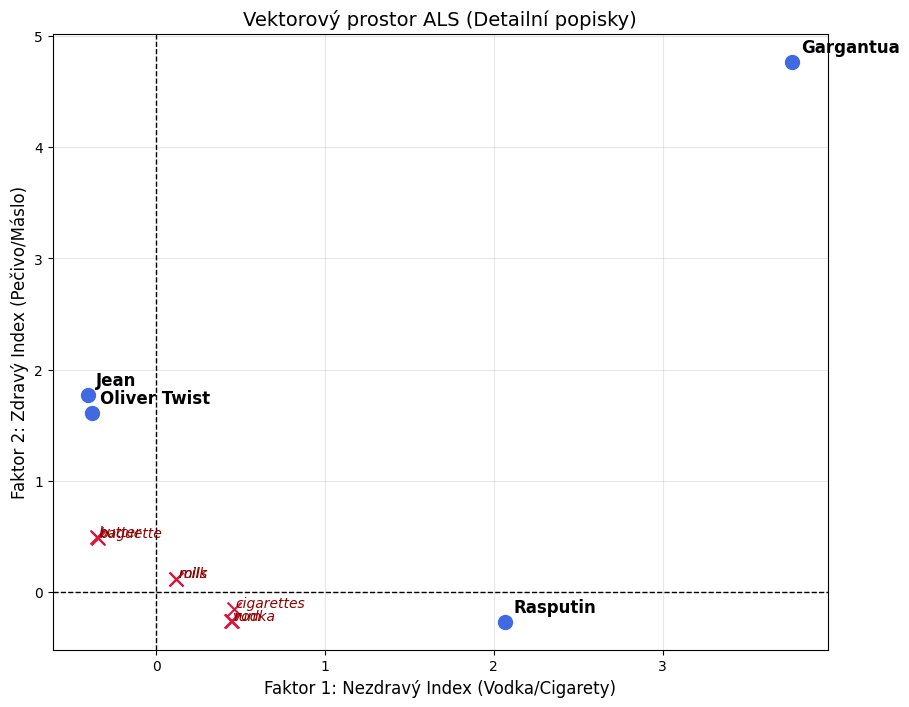

In [16]:
import matplotlib.pyplot as plt

# Získáme vektory
user_vecs = model.user_factors
item_vecs = model.item_factors

plt.figure(figsize=(10, 8))

# 1. Uživatelé (Modré body)
for i, name in user_names.items():
    plt.scatter(user_vecs[i, 0], user_vecs[i, 1], marker='o', color='royalblue', s=100)
    # Menší offset (0.05) zajistí, že jméno bude hned u tečky
    plt.text(user_vecs[i, 0] + 0.05, user_vecs[i, 1] + 0.05, name, 
             fontsize=12, fontweight='bold', ha='left', va='bottom')

# 2. Produkty (Červené křížky)
for i, name in product_names.items():
    plt.scatter(item_vecs[i, 0], item_vecs[i, 1], marker='x', color='crimson', s=100)
    # Pro produkty u nuly dáme ještě menší offset, aby se nepřekrývaly
    plt.text(item_vecs[i, 0] + 0.01, item_vecs[i, 1] + 0.01, name, 
             fontsize=10, fontstyle='italic', color='darkred')

# POJMENOVÁNÍ OS
plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.xlabel("Faktor 1: Nezdravý Index (Vodka/Cigarety)", fontsize=12)
plt.ylabel("Faktor 2: Zdravý Index (Pečivo/Máslo)", fontsize=12)
plt.title("Vektorový prostor ALS (Detailní popisky)", fontsize=14)

# Nastavení limitů os, aby graf nebyl moc "roztažený" nebo "smrštěný"
plt.grid(alpha=0.3)
plt.show()

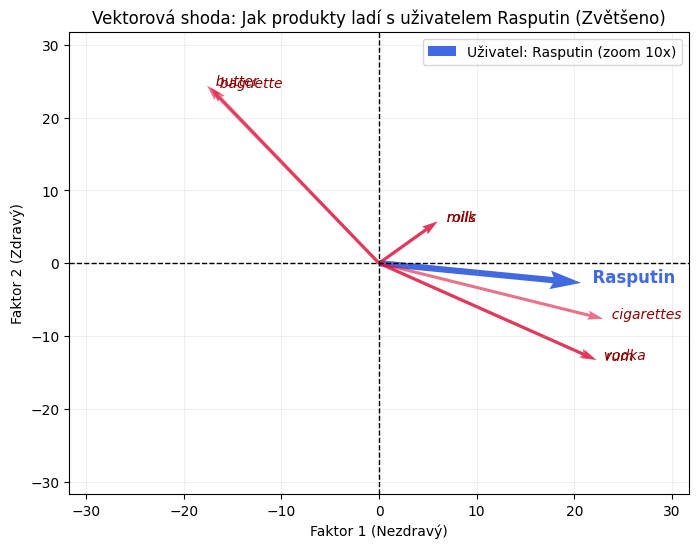

In [17]:
# --- NASTAVENÍ UŽIVATELE A ZOOMU ---

u_vec = model.user_factors[user_id_to_check]
i_vecs = model.item_factors
u_name = user_names[user_id_to_check]

# Zde nastavuješ protažení šipek
user_zoom = 10  # <--- ZVĚTŠENÍ MODRÉHO VEKTORU (uprav podle potřeby)
item_zoom = 50  # <--- ZVĚTŠENÍ ČERVENÝCH VEKTORŮ

plt.figure(figsize=(8, 6))

# 1. Vykreslení vektoru uživatele (PROTAŽENÁ MODRÁ ŠIPKA)
plt.quiver(0, 0, u_vec[0] * user_zoom, u_vec[1] * user_zoom, 
           angles='xy', scale_units='xy', scale=1, 
           color='royalblue', width=0.01, label=f'Uživatel: {u_name} (zoom {user_zoom}x)')

# Text u špičky modrého vektoru
plt.text(u_vec[0] * user_zoom, u_vec[1] * user_zoom, f"  {u_name}", 
         fontsize=12, fontweight='bold', color='royalblue')

# 2. Vykreslení vektorů všech produktů (ČERVENÉ ŠIPKY)
for i, name in product_names.items():
    iv = i_vecs[i] * item_zoom
    plt.quiver(0, 0, iv[0], iv[1], angles='xy', scale_units='xy', scale=1, 
               color='crimson', alpha=0.6, width=0.005)
    
    # Text u špiček produktů
    plt.text(iv[0], iv[1], f"  {name}", fontsize=10, fontstyle='italic', color='darkred')

# --- FORMÁTOVÁNÍ GRAFU ---
plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.grid(alpha=0.2)

# Automatické nastavení limitů grafu podle nejdelší šipky
limit = max(
    np.abs(u_vec * user_zoom).max(), 
    np.abs(i_vecs * item_zoom).max()
) * 1.3

plt.xlim(-limit, limit)
plt.ylim(-limit, limit)

plt.xlabel("Faktor 1 (Nezdravý)")
plt.ylabel("Faktor 2 (Zdravý)")
plt.title(f"Vektorová shoda: Jak produkty ladí s uživatelem {u_name} (Zvětšeno)")
plt.legend()
plt.show()

# ALS - neural approach

In [123]:
data = pd.read_excel('in/data-02.xlsx')
data

,user_id,user_name,user_feature,user_feature_bin,order_id,item_id,item_name,count,diary,bakery,alcohol,tabaco,food,drink,unhealthy,healthy
0,0,Oliver Twist,alcoholic,1,1,0,butter,1,1,0,0,0,1,0,0,1
1,1,Jean,teetotaller,0,2,0,butter,5,1,0,0,0,1,0,0,1
2,1,Jean,teetotaller,0,3,1,baguette,10,0,1,0,0,1,0,0,1
3,2,Rasputin,alcoholic,1,4,2,vodka,2,0,0,1,0,0,1,1,0
4,2,Rasputin,alcoholic,1,5,3,cigarettes,2,0,0,0,1,0,0,1,0
5,2,Rasputin,alcoholic,1,6,6,rum,5,0,0,1,0,0,1,1,0
6,3,Gargantua,teetotaller,0,7,1,baguette,15,0,1,0,0,1,0,0,1
7,3,Gargantua,teetotaller,0,8,4,rolls,10,0,1,0,0,1,0,0,1
8,3,Gargantua,teetotaller,0,9,5,milk,20,1,0,0,0,0,1,0,0
9,3,Gargantua,teetotaller,0,10,3,cigarettes,5,0,0,0,1,0,0,1,0


In [124]:
# 2. Faktorizace a Mapování
data["user_idx"] = pd.factorize(data["user_id"])[0]
data["item_idx"] = pd.factorize(data["item_id"])[0]
data

,user_id,user_name,user_feature,user_feature_bin,order_id,item_id,item_name,count,diary,bakery,alcohol,tabaco,food,drink,unhealthy,healthy,user_idx,item_idx
0,0,Oliver Twist,alcoholic,1,1,0,butter,1,1,0,0,0,1,0,0,1,0,0
1,1,Jean,teetotaller,0,2,0,butter,5,1,0,0,0,1,0,0,1,1,0
2,1,Jean,teetotaller,0,3,1,baguette,10,0,1,0,0,1,0,0,1,1,1
3,2,Rasputin,alcoholic,1,4,2,vodka,2,0,0,1,0,0,1,1,0,2,2
4,2,Rasputin,alcoholic,1,5,3,cigarettes,2,0,0,0,1,0,0,1,0,2,3
5,2,Rasputin,alcoholic,1,6,6,rum,5,0,0,1,0,0,1,1,0,2,4
6,3,Gargantua,teetotaller,0,7,1,baguette,15,0,1,0,0,1,0,0,1,3,1
7,3,Gargantua,teetotaller,0,8,4,rolls,10,0,1,0,0,1,0,0,1,3,5
8,3,Gargantua,teetotaller,0,9,5,milk,20,1,0,0,0,0,1,0,0,3,6
9,3,Gargantua,teetotaller,0,10,3,cigarettes,5,0,0,0,1,0,0,1,0,3,3


In [ ]:
# 1. PŘÍPRAVA DAT (použijeme tvé indexy z předchozích kroků)

u_indices = data["user_idx"].values
i_indices = data["item_idx"].values
counts = data["count"].values.astype(np.float32)

num_users = len(user_idx_to_name)
num_items = len(item_idx_to_name)
embedding_dim = 2  # Držíme 2D pro tvůj graf

# --- ARCHITEKTURA TWO-TOWERS ---

# TOWER UŽIVATELE (User Tower)
user_input = layers.Input(shape=(1,), name="User_Input")
user_embed = layers.Embedding(num_users, embedding_dim, name="User_Embedding")(user_input)
user_vec = layers.Flatten(name="User_Vector")(user_embed)

# TOWER PRODUKTU (Item Tower)
item_input = layers.Input(shape=(1,), name="Item_Input")
item_embed = layers.Embedding(num_items, embedding_dim, name="Item_Embedding")(item_input)
item_vec = layers.Flatten(name="Item_Vector")(item_embed)

# SPOJENÍ (Dot Product) - simuluje shodu vektorů v prostoru
#
output = layers.Dot(axes=1, name="Dot_Product")([user_vec, item_vec])

# FINÁLNÍ MODEL
model_tt = Model(inputs=[user_input, item_input], outputs=output)

model_tt.compile(optimizer=tf.keras.optimizers.Adam(0.1), 
                 loss="mse",
                 )


# 2. TRÉNINK
model_tt.fit(
            x = [u_indices, i_indices], 
            y = np.ones(len(data)),
            epochs=400, 
            sample_weight = np.log1p(data['count']),
            verbose=0
            )

print("Model Two-Tower byl úspěšně vytrénován.")

# 3. ZÍSKÁNÍ VEKTORŮ (Embeddings) PRO GRAF
user_embeddings = model_tt.get_layer("User_Embedding").get_weights()[0]
item_embeddings = model_tt.get_layer("Item_Embedding").get_weights()[0]

Model Two-Tower byl úspěšně vytrénován.


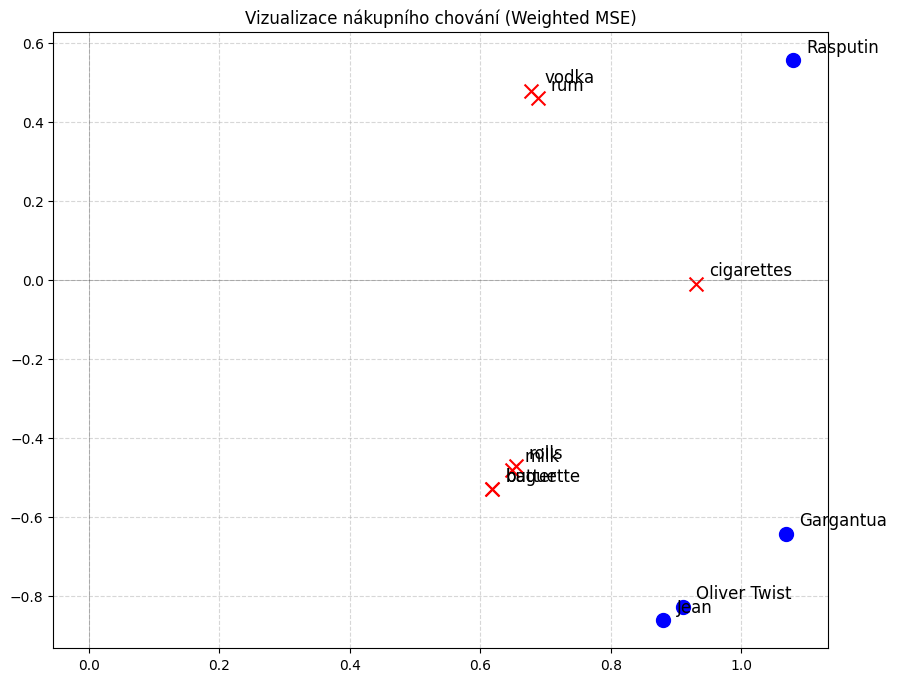

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Vykreslení uživatelů (modré kroužky)
for i, name in user_idx_to_name.items():
    plt.scatter(user_embeddings[i, 0], user_embeddings[i, 1], color='blue', s=100)
    plt.text(user_embeddings[i, 0] + 0.02, user_embeddings[i, 1] + 0.02, name, fontsize=12)

# Vykreslení produktů (červené křížky)
for i, name in item_idx_to_name.items():
    plt.scatter(item_embeddings[i, 0], item_embeddings[i, 1], color='red', marker='x', s=100)
    plt.text(item_embeddings[i, 0] + 0.02, item_embeddings[i, 1] + 0.02, name, fontsize=12)

plt.axhline(0, color='black', linewidth=0.5, alpha=0.3)
plt.axvline(0, color='black', linewidth=0.5, alpha=0.3)
plt.title("Vizualizace nákupního chování (Weighted MSE)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [128]:
# 1. Najdeme index Olivera Twista
target_user = "Oliver Twist"
#target_user = "Rasputin"
user_id = [idx for idx, name in user_idx_to_name.items() if name == target_user][0]

# 2. Vytáhneme jeho embedding (vektor) z "User věže"
oliver_vector = user_embeddings[user_id]

# 3. VÝPOČET SHODY (Dot Product)
# V GCP by toto dělal Vector Search bleskově pro miliony položek
scores = np.dot(item_embeddings, oliver_vector)

# 4. SEŘAZENÍ A VÝPIS
print(f"\nDoporučení pro: {target_user}")
print("-" * 35)

# Seřadíme indexy produktů podle skóre od nejvyššího
recommended_indices = np.argsort(scores)[::-1]

for idx in recommended_indices:
    name = item_idx_to_name[idx]
    score = scores[idx]
    print(f"{name:<15} | skóre: {score:7.3f}")


Doporučení pro: Oliver Twist
-----------------------------------
butter          | skóre:   1.000
baguette        | skóre:   1.000
milk            | skóre:   0.986
rolls           | skóre:   0.983
cigarettes      | skóre:   0.854
rum             | skóre:   0.244
vodka           | skóre:   0.221


# Two tower - dense layer - both sides

In [ ]:
df = pd.read_excel('in/data-02.xlsx')
df.head(5)

,user_id,user_name,user_feature,user_feature_bin,order_id,item_id,item_name,count,diary,bakery,alcohol,tabaco,food,drink,unhealthy,healthy
0,0,Oliver Twist,alcoholic,1,1,0,butter,1,1,0,0,0,1,0,0,1
1,1,Jean,teetotaller,0,2,0,butter,5,1,0,0,0,1,0,0,1
2,1,Jean,teetotaller,0,3,1,baguette,10,0,1,0,0,1,0,0,1
3,2,Rasputin,alcoholic,1,4,2,vodka,2,0,0,1,0,0,1,1,0
4,2,Rasputin,alcoholic,1,5,3,cigarettes,2,0,0,0,1,0,0,1,0


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
# Automatické indexování pro embeddingy
df["u_idx"] = pd.factorize(df["user_id"])[0]
df["i_idx"] = pd.factorize(df["item_id"])[0]


In [ ]:
# --- 1. PŘÍPRAVA DAT (Tvoje definice) ---
# Seznam všech 8 sloupců metadat
feature_cols = ['diary', 'bakery', 'alcohol', 'tabaco', 'food', 'drink', 'unhealthy', 'healthy', 
                #"item_pop_log_scaled"
                
                ]

user_feature_cols = ['user_feature_bin']

# Matice metadat
item_meta_matrix = df[['i_idx'] + feature_cols].drop_duplicates().sort_values('i_idx').set_index('i_idx').values
user_meta_matrix = df[['u_idx'] + user_feature_cols].drop_duplicates().sort_values('u_idx').set_index('u_idx').values

# Konstanty
num_users = df.u_idx.nunique()
num_items = df.i_idx.nunique()
num_features = len(feature_cols) # To je 8
embedding_dim = 10

# --- 2. ARCHITEKTURA (Two-Tower) ---

# USER TOWER
u_id_in = layers.Input(shape=(1,), name="User_In")
u_meta_in = layers.Input(shape=(len(user_feature_cols),), name="User_Meta_In")
u_emb = layers.Flatten()(layers.Embedding(num_users, embedding_dim)(u_id_in))
u_combined = layers.Concatenate()([u_emb, u_meta_in])

u_combined = layers.Dropout(0.2)(u_combined)

u_vec = layers.Dense(embedding_dim, 
                     #activation='relu', 
                     name="User_Vector"
                     )(u_combined)

# ITEM TOWER
i_id_in = layers.Input(shape=(1,), name="Item_In")
i_meta_in = layers.Input(shape=(num_features,), name="Item_Meta_In") 
i_emb = layers.Flatten()(layers.Embedding(num_items, embedding_dim)(i_id_in))
i_combined = layers.Concatenate()([i_emb, i_meta_in])

i_combined = layers.Dropout(0.2)(i_combined)

item_vec = layers.Dense(embedding_dim, 
                        #activation='relu', 
                        name="Item_Vector"
                        )(i_combined)

# VÝSTUP
output = layers.Dot(axes=1, name="Similarity")([u_vec, item_vec])

# FINÁLNÍ SESTAVENÍ
model_rich = Model(inputs=[u_id_in, u_meta_in, i_id_in, i_meta_in], outputs=output)
model_rich.compile(optimizer="adam", 
                   loss="mse",
                   #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
                   )

print("Model je úspěšně sestaven a připraven!")

Model je úspěšně sestaven a připraven!


In [ ]:
# 1. Příprava vstupních dat (X) a cíle (y)
# Vstupy musí být ve stejném pořadí jako: [u_id_in, u_meta_in, i_id_in, i_meta_in]

X = [
    df['u_idx'].values,             # User IDs
    df[user_feature_cols].values,   # User Metadata (user_feature_bin)
    df['i_idx'].values,             # Item IDs
    df[feature_cols].values         # Item Metadata (těch 8 kategorií)
]

# Cílová proměnná (y) - podle tvého screenu je to 'count'
y = np.ones(len(df))

# 2. Samotný trénink
history = model_rich.fit(
    x=X,
    y=y,
    epochs=500,          # Kolikrát model projde celá data
    batch_size=32,      # Počet vzorků v jednom kroku aktualizace vah
    #validation_split=0.2, # 20% dat si odloží na testování přesnosti
    sample_weight = np.log1p(df['count']),
    verbose=0
)

In [ ]:
final_loss = history.history['loss'][-1]
print(f"Final loss {final_loss}")

Final loss 0.034611672163009644


In [ ]:
# --- 3. PŘEDPOVĚĎ (PREDIKCE) ---

# 1. OPRAVA MAPOVÁNÍ (přiřazujeme indexům skutečná jména z DataFrame)
# Toto zajistí, že uvidíš 'butter' místo '0'
item_map = dict(zip(df.i_idx, df.item_name))
user_map = dict(zip(df.u_idx, df.user_name))

# 2. PŘÍPRAVA DAT PRO MODEL
all_metadata = item_meta_matrix 
all_item_ids = np.arange(num_items)

# Výběr uživatele (Oliver Twist = 0, Jean = 1, Rasputin = 2)
target_idx = 2
user_id_input = np.full(num_items, target_idx)

# Získání metadat uživatele (např. zda je alcoholic) a jejich rozmnožení pro všechny produkty
user_meta = user_meta_matrix[target_idx]
user_meta_input = np.tile(user_meta, (num_items, 1))

# 3. VOLÁNÍ MODELU
# Vstupy musí odpovídat definici: [u_id, u_meta, i_id, i_meta]
predicted_scores = model_rich.predict([
    user_id_input,      # User_In
    user_meta_input,    # User_Meta_In
    all_item_ids,       # Item_In
    all_metadata        # Item_Meta_In
])

# 4. SESTAVENÍ TABULKY VÝSLEDKŮ SE JMÉNY
results = []
for i in range(num_items):
    idx = all_item_ids[i]
    results.append({
        "item_name": item_map[idx], # Tady se nyní vytáhne název (např. butter)
        "score": round(float(predicted_scores[i][0]), 4)
    })

results_df = pd.DataFrame(results).sort_values(by="score", ascending=False)

# VÝPIS
print(f"Doporučení pro: {user_map[target_idx]}")
print("-" * 30)
print(results_df.to_string(index=False))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Doporučení pro: Rasputin
------------------------------
 item_name  score
      milk 1.0345
       rum 0.9423
     vodka 0.9291
cigarettes 0.9236
    butter 0.5903
  baguette 0.5014
     rolls 0.4578


# Offline testing

In [ ]:
import pandas as pd

# seřadíme podle času / order_id
df = df.sort_values(["user_id", "order_id"])

# poslední nákup každého usera = test
test_df = df.groupby("user_id").tail(1)

# zbytek = train
train_df = df.drop(test_df.index)


In [ ]:
test_df

,user_id,user_name,user_feature,user_feature_bin,order_id,item_id,item_name,count,diary,bakery,alcohol,tabaco,food,drink,unhealthy,healthy,u_idx,i_idx
0,0,Oliver Twist,alcoholic,1,1,0,butter,1,1,0,0,0,1,0,0,1,0,0
2,1,Jean,teetotaller,0,3,1,baguette,10,0,1,0,0,1,0,0,1,1,1
5,2,Rasputin,alcoholic,1,6,6,rum,5,0,0,1,0,0,1,1,0,2,4
10,3,Gargantua,teetotaller,0,11,0,butter,10,1,0,0,0,1,0,0,1,3,0


In [ ]:
def popularity_recommender(train_df, k=5):
    top_items = (
        train_df["item_id"]
        .value_counts()
        .head(k)
        .index
        .tolist()
    )
    return top_items


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

num_users = df["user_id"].nunique()
num_items = df["item_id"].nunique()
embedding_dim = 8

# inputs
u_in = layers.Input(shape=(1,))
i_in = layers.Input(shape=(1,))

# embeddings
u_emb = layers.Flatten()(layers.Embedding(num_users, embedding_dim)(u_in))
i_emb = layers.Flatten()(layers.Embedding(num_items, embedding_dim)(i_in))

# similarity
score = layers.Dot(axes=1)([u_emb, i_emb])

model = Model([u_in, i_in], score)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)


In [ ]:
import numpy as np

def make_training_data(train_df, num_items, n_neg=3):
    X_u, X_i, y = [], [], []

    user_items = train_df.groupby("user_id")["item_id"].apply(set)

    for u, i in zip(train_df.user_id, train_df.item_id):
        # pozitivní
        X_u.append(u)
        X_i.append(i)
        y.append(1)

        # negativní
        for _ in range(n_neg):
            neg = np.random.randint(0, num_items)
            if neg not in user_items[u]:
                X_u.append(u)
                X_i.append(neg)
                y.append(0)

    return np.array(X_u), np.array(X_i), np.array(y)


Xu, Xi, y = make_training_data(train_df, num_items)

model.fit(
    [Xu, Xi],
    y,
    epochs=50,
    batch_size=10,
    verbose=0
)


In [ ]:
def recommend_nn(model, user_id, all_items, k=3):
    users = np.full(len(all_items), user_id)
    scores = model.predict([users, all_items], verbose=0).reshape(-1)
    top_k = all_items[np.argsort(scores)[::-1][:k]]
    return set(top_k)


In [ ]:
def recall_at_k(test_df, recommend_func, k=3):
    hits = []

    all_items = np.arange(num_items)

    for _, row in test_df.iterrows():
        u = row.user_id
        true_item = row.item_id

        recs = recommend_func(u, all_items, k)
        hits.append(true_item in recs)

    return sum(hits) / len(hits)



In [ ]:
# A – popularity
popular_items = popularity_recommender(train_df, k=3)
recall_A = recall_at_k(
    test_df,
    lambda u, items, k: set(popular_items),
    k=3
)

# B – NN
recall_B = recall_at_k(
    test_df,
    lambda u, items, k: recommend_nn(model, u, items, k),
    k=3
)

print(f"Recall@5 A (baseline): {recall_A:.3f}")
print(f"Recall@5 B (two-tower): {recall_B:.3f}")


Recall@5 A (baseline): 0.500
Recall@5 B (two-tower): 0.500
